In [21]:
import tabulate
import json
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np
plt.style.use('science')


In [22]:
with open("data/qualitative_results.json", "r") as f:
    projects = json.loads(f.read())

In [23]:
df = pd.read_json("data/qualitative_results.json")

In [24]:
# Organize data for visualization
causes = {}
statuses = ["Merged", "Approved", "Possitive Feedback", "Pending", "Rejected"]
projects_per_status = {s: set() for s in statuses}  # Track unique projects per status


for project, deps in projects.items():
    for dep, details in deps.items():
        cause = details["Root Cause"]
        status = details["PR Status"]
        if status in statuses:
            if cause not in causes:
                causes[cause] = {s: 0 for s in statuses}
            causes[cause][status] += 1
            projects_per_status[status].add(project)


labels = list(causes.keys())

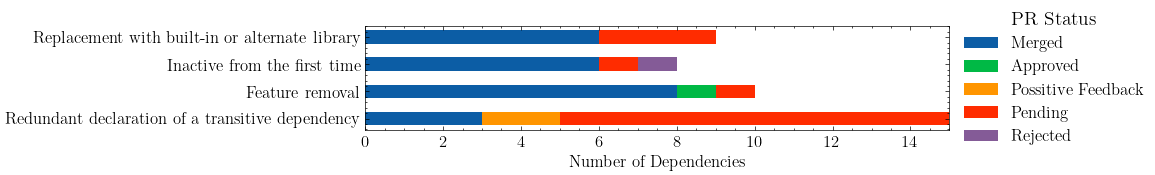

In [25]:
bottom = np.zeros(len(labels))

# Adjusting the figure size based on the number of labels
fig, ax = plt.subplots(figsize=(10, 0.5 * len(labels)))

for i, status in enumerate(statuses):
    counts = [causes[label][status] for label in labels]
    ax.barh(labels, counts, left=bottom, label=status, height=0.5)  # Adjust bar thickness with height
    bottom += counts

# Set xlabel with appropriate font size
ax.set_xlabel('Number of Dependencies', fontsize=12)

# Create space to the right of the plot
fig.subplots_adjust(right=0.7)

# Adjust the yticks and xticks font sizes
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.tight_layout(pad=2.0)

# Set the legend outside the plot on the right
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={"size": 12})
legend.set_title("PR Status", prop={"size": 14})
ax.set_xlim(0, 15)  # Adjust x-axis limits

plt.gca().invert_yaxis() 
plt.savefig("figures/rq4.pdf", bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()


In [26]:
total_prs = sum([len(projects_per_status[status]) for status in statuses])
total_deps_removed = sum([causes[cause][status] for cause in causes for status in statuses])

latex_table = r"""
\begin{table}[h]
\caption{Pull Request (PR) Outcomes for Removal of Bloated Direct Dependencies}
\label{tab:pr_outcomes}
\centering
\resizebox{0.9\linewidth}{!}{
\begin{tabular}{lrr}
\hline
{\bf PR Status} & {\bf Number of PRs} & {\bf Number of Direct Dependencies Removed} \bigstrut\\
\hline
"""

for status in statuses:
    num_prs = len(projects_per_status[status])
    num_deps_removed = sum([causes[cause][status] for cause in causes if status in causes[cause]])
    latex_table += f"{status} & \\nnum{{{num_prs}}} & \\nnum{{{num_deps_removed}}} \\\\\n" 

latex_table += f"\\hline\nTotal & \\nnum{{{total_prs}}} & \\nnum{{{total_deps_removed}}} \\bigstrut \\\\\n\\hline\n"

latex_table += r"""
\end{tabular}}
\end{table}
"""

with open("tables/rq4_pr_status.tex", "w") as file:
    file.write(latex_table)


